# Lab 4 : Non-negative Matrix Factorization

The goal of this lab session is to code a NMF algorithm and use it in some applications.


We begin with the standard imports:

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

# NMF - Recap

Non-negative Matrix Factorization is a model where a matrix X is factorized into two matrices W and H, with the property that all three matrices have no negative elements. This non-negativity makes the resulting matrices easier to interpret.


Loss (Regularized Froebnius): $\mathcal{L}(W, H) = \frac{1}{2}\|X-W H\|_{F}^{2}+ \color{red}{\frac{\mu}{2}\|H\|_{F}^{2}+\lambda\|H\|_{1}+\frac{\nu}{2}\|W\|_{F}^{2}}$

Algorithm (multiplicative updates from [Lee and Seung, 1999] (http://papers.nips.cc/paper/1861-algorithms-for-non-negative-matrix-factorization.pdf)

\begin{array}{c}
W \leftarrow W .* \left(X H^T\right)./W \left(H H^{\top} + {\color{red} \nu I_r}\right) \\
H \leftarrow H .* \left(W^{\top} X - {\color{red} \lambda 1_{r \times n}}\right)./\left((W^{\top} W + {\color{red} \mu I_r})H\right)
\end{array}


.* is the dot product ( in python  : A*B ) 

AB is the matrix product ( in python : A@B )

## Initialization 

The computation time and the convergence of the NMF depends on how you initialize the matrices W and H.
You will implement and compare two types of initialization. 

#### Random initialization : 

$\forall i,j, H^0_{i,j}\sim U_{[0,1]}$ and $ W^0_{i,j}\sim U_{[0,1]} $

Each term of $W^0$ and $H^0$ is sampled with a uniform distribution. Use np.random.random(Matrix_shape)

#### NNDSVD initialization : 

Singular value decomposition (SVD) is a classical method that extends the eigen-decomposition to non-square matrix.

For any $ X \in \mathbb{R}^{N\times M}$, there exists a factorization with the following form:

$$ X = U \Sigma V^T $$

With $ U \in \mathbb{R}^{N\times N} , \Sigma  \in \mathbb{R}^{N\times M} \text{ such as } \Sigma = \begin{pmatrix} 
\Sigma_1 & 0 \\
0 & 0 
\end{pmatrix} , V \in \mathbb{R}^{M\times M} $



$\Sigma_1 = diag(σ1, σ2, ..., σr)$, and the diagonal entries are sorted in descending order, i.e. σ1 ≥ σ2 ≥ ... ≥ σr > 0,
σi, i = 1, 2, ...r being the singular values with r = rank(Z)


After the computation of the SVD of X, the initialization of W and H is made with  

$$ W^0 = |U_{:,:r}|$$
$$ H^0 = | \Sigma_{:r,:}V^T| $$ 
$|.|$ means the absolute value for each term of the matrix, r = number of components of the NMF :

You will need : 
np.linalg.svd 

Watch out np.linalg.svd returns only the diagonal of $\Sigma$. I advise you ton create a empty matrix $\Sigma$ with np.zeros(Shape of the matrix) then fill the diagonal with np.diag(). You can use the exemple in https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html



### Tasks  :  
- Fill the fit transform function. Consider $\mathcal{L}(W, H) = \frac{1}{2}\|X-W H\|_{F}^{2}$ (no regularization)
- Implement NNSVD initialization and random initialization. 
- Return W H and the Froebenius norm of the residuals (the loss) when the convergence condition is fulfilled.

(This should take you less than 30 minutes)

In [62]:
class my_NMF():
    
    def __init__(self, n_components, epsilon,init, max_iter = 60):
        '''
        Attributes:
        
        n_components_ : integer
            the unknown dimension of W and H
        max_iter_: integer
            maximum number of iterations
        epsilon_ : float
        init_ :  {"random", "NNDSVD"}
        w_: np.array
            W Matrix factor
        H_: np.array
            H Matrix factor
        '''
        self.n_components = n_components
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.init = init
        self.W = None
        self.H = None
        
        
    def fit_transform(self, X):
        """ Find the factor matrices W and H
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        W,H,loss
        """        
        n, p = X.shape
        #loss = 42
        
        
        if self.init == 'NNDSVD' : 
            #TODO
            #Initialize W and H with a SVD of X
            U, Sigm, Vt = np.linalg.svd(X, full_matrices=False)
            #print(U.shape, Sigm.shape, Vt.shape)
            #S = np.zeros( (n, p), dtype=complex)
            S = np.diag(Sigm)
            #print(np.allclose(X, np.dot(U, np.dot(S, Vt))))
            
            self.W = np.abs(U[:,:self.n_components])
            self.H = np.abs(np.dot(S[:self.n_components,:], Vt))
            
        elif self.init == 'random' :
#             #TODO
            #Initialize W and H by generating uniform samples.
            self.W = np.random.random((X.shape[0],self.n_components))
            self.H = np.random.random((self.n_components,X.shape[1]))
        
        convergence = False 
        counter = 0
        
        while not(convergence) : 
            #The convergence is reached when the number of iteration is equal to self.max_iter or
            #when the loss < self.epsilon
            
            #R = self.W @ self.H - X
            self.W = self.W *  np.divide(np.dot(X,self.H.T), np.dot(self.W, np.dot(self.H , self.H.T)))
            self.H = self.H * np.divide(np.dot(self.W.T, X) , np.dot(self.W.T, np.dot(self.W,self.H))) 
            #R@G.T + self.penalty(self.W, lamd)
            loss = 1/2 * np.linalg.norm(X - np.dot(self.W, self.H)) **2
            #TODO 
            #Update W and H for each iteration
        
            counter += 1
            if (counter == self.max_iter) or (loss < self.epsilon):
                convergence = True 
        print(self.W.shape, self.H.shape)
        return self.W,self.H,loss


### Bonus : Implement the regularized version

## Applications

### First application - Images

For the first application you are going to analyse the following data to give an interpretation of the factorization:

(400, 4096)

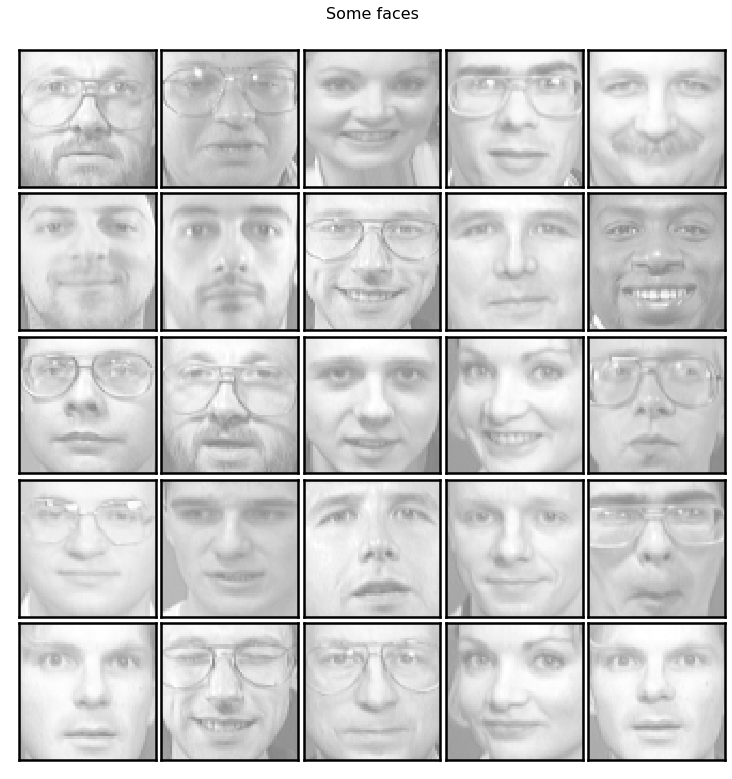

In [63]:
from sklearn.datasets import fetch_olivetti_faces

dataset = fetch_olivetti_faces(shuffle=True)

faces = dataset.data
image_shape = (64, 64)

n_samples, n_features = faces.shape

def plot_faces(title, images, image_shape, n_col=5, n_row=5, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    
plot_faces("Some faces", faces[:25], image_shape)

faces.shape

### Task : apply your NMF algorithm to this dataset and plot some approximated face pictures. Compare the different initializations

### Tasks :  
- Apply NMF with the SVD initialisation and with a number of components r such as $\sqrt r$ is an integer (r = 4,16,etc..) 
- Plot the $H$ matrix as images in a $(\sqrt{r}, \sqrt{r})$ grid ( n_col=n_row=$\sqrt r $)
- Choose one face, plot its corresponding weights (in $W$) in a grid 
- How can we interpret the matrices H and W.

Be careful with the arguments image_shape, n_col n_row in the plot_faces function

(400, 5) (5, 4096)


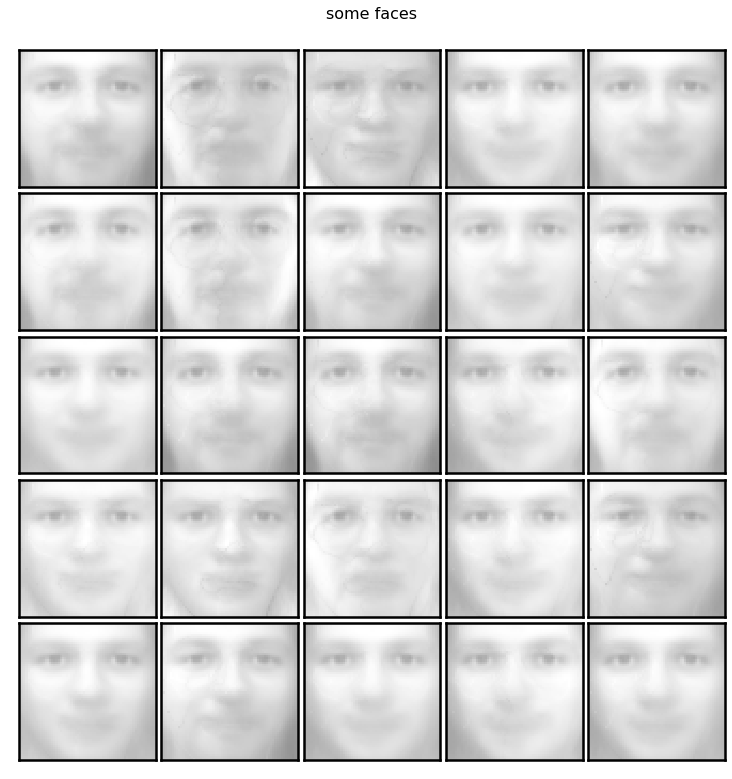

In [66]:
NMF = my_NMF(5, 1e-2, "NNDSVD")
W, H, loss = NMF.fit_transform(faces)
plot_faces("some faces", (W@H)[:25], image_shape)

In [ ]:
NMF = my_NMF(5, 1e-2, "random")
W, H, loss = NMF.fit_transform(faces)
plot_faces("some faces", (W@H)[:25], image_shape)

### Second application

Import the 20newsgroups dataset (from sklearn.datasets import fetch_20newsgroups_vectorized) that contains a collection of ~18,000 news documents from 20 different newsgroups (i.e 20 different topics like art news, geopolitical news etc...)

The goal of this exercice is to model the topics present with NMF then print the most common words of each topic.

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups

n_samples = 5000
n_features = 2000
n_components = 10
n_top_words = 20

def print_top_words(D, feature_names, n_top_words):
    p, r = D.shape
    for topic_idx in range(r):
        topic = D[:, topic_idx]
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data[:n_samples]


print(data_samples[:3]) # A few exemple of news 

["Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n", "\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap 

### Feature extraction/engineering 

Before applying NMF, you have to convert text into numerical values in order to vectorize your documents.

We will be looking at the Count vectorizer method and the TF-IDF vectorizer.

### Count vectorizer. 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

We define a corpus by an ensemble of documents $(D_1,...D_N)$. From this corpus we collect all the different words used in the documents, this collection of words $(w_1,...w_p)$ is called the vocabulary of the corpus.

Using the count vectorizer, the numerical representation of a document $D_i$ will be Count_Vectoriser$(D_i) = \sum_{j=1}^p f_{ij}w_j $ With f_ij, the frequency of appearence of the word $w_j$ in the document $i$.

### TF-IDF

Task : Search for TF-IDF. Explain its principle and its difference with count_vectorizer

Answer : TF-IDF looks for the overall document weightage of a word, wheras count_vectorizer only finds the frequency/total count of the word. 



### Task : Vectorize your document with Count Vectorizer or TF-IDF. 
#### Put in argument stop_words='english'  and max_features=n_features 
Stop_words is a list of common words that don't bring any information like 'the', 'a' etc... We don't want these words to take up space in our database for computation time reason and because they could harm the numerical representation of the documents. 

You must obtain a $5000\times2000$ shaped matrix 

In [49]:
# TODO
import numpy as np
vectorizer = CountVectorizer(stop_words='english', max_features=n_features)
X = vectorizer.fit_transform(dataset.data)
vectorizer.get_feature_names_out()


X = X.toarray()
X = X[:5000,]
X.shape

(5000, 2000)


### Task : Apply NMF from sklearn with a choosen initialization. Then print the top words for each topics with print_top_words

Use tfidf_vectorizer.get_feature_names() to recover the words. 

In [50]:
from sklearn.decomposition import NMF
from time import time
import matplotlib.pyplot as plt

In [55]:
model = NMF(n_components, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

np.shape(H)


(10, 2000)

In [56]:
def print_top_words(D, feature_names, n_top_words):
    p, r = D.shape
    for topic_idx in range(p):
        topic = D[topic_idx,:]
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]]) #best 20 word for each topic (best is the best 20 that have the highers tfidf_score per topic)
        print(message)
    print()

In [58]:
print_top_words(H, tfidf_vectorizer.get_feature_names_out(), n_top_words)

Topic #0: baltimore memory given basically account 2d 15 84 black 1d9 political 10 graphics 1t 89 great baseball 400 basic boards
Topic #1: david came say club lose 17 illegal clear wait spend _____ killed waco network team day starting calling mentioned 15
Topic #2: project israeli insurance english em qy appears connection engine user marriage generally nt sense null florida r3 usual papers entirely
Topic #3: 00 drive 41 52 apr 1000 association 20 25 150 91 1st 77 30 63 null 01 81 crowd 000
Topic #4: nazi students problems large draft times sb ground difficult happens past term kids yes process screen loss control door dec
Topic #5: efforts half qy comp marriage generally session 13 record 3d sgi damage b8 operation computer includes included answers folks converter
Topic #6: pin kids digital large sb draft lives times greeks tool went carried difficult ground companies screen town step types appreciate
Topic #7: florida hardware contains count fonts story nazi unless id 1991 1992 le

The relevance of the topics can be improved with better parameters in the vectorizer, a more advanced cleaning in addition to the stopwords (for instance getting rid of the numbers etc ...) or more advanced vectorizer/encoder like Word2Vec or Doc2Vec which use very simple neural networks. 

### Imagine we would like to gather the news coming from the same newsgroup/news category. How would you do using the NMF and the previous courses ? 

Answer : we know there are 20 categories, so we group by these components and then take the NMF algorithm


### Implement your solution.

In [59]:
n_components=20
model = NMF(n_components, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

np.shape(H)

(20, 2000)

In [60]:
g=vectorizer.get_feature_names()

/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [61]:
print_top_words(H, g, n_top_words)

Topic #0: ax max g9v b8f a86 1d9 pl 75u bhj giz 1t 7ey gk b4q bj b8e qq 3t lg 2di
Topic #1: mr stephanopoulos president know don think said going did groups package tax just yes press say ll considered does day
Topic #2: privacy pub eff internet electronic email ftp information computer anonymous org mail public network security law list file issues use
Topic #3: 00 dos 40 50 appears art 10 25 20 15 80 1st 70 01 30 60 cover 000 appear new
Topic #4: god ra jesus bible does believe people good true christ christian say just religion faith subject father spirit posting know
Topic #5: edu com os comp cs ca version yes type ibm machines john comments contact vote misc org dos ftp david
Topic #6: people didn said just know don think like went going came time come apartment took building did started happened woman
Topic #7: file gun congress control firearms mr states united house 1991 1992 law amendment 1993 crime american senate use code second
Topic #8: widget application visual resource t